In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class CDAutoEncoder(nn.Module):
    """
    Convolutional denoising autoencoder layer for stacked autoencoders.
    This module is automatically trained when in model.training is True.

    Args:
        input_size: The number of features in the input
        output_size: The number of features to output
        stride: Stride of the convolutional layers.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=2, stride=stride, padding=0),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        # Train each autoencoder individually
        x = x.detach()
        # Add noise, but use the original lossless input as the target.
        x_noisy = x * (Variable(x.data.new(x.size()).normal_(0, 0.1)) > -.1).type_as(x)
        y = self.forward_pass(x_noisy)

        if self.training:
            x_reconstruct = self.backward_pass(y)
            #loss = self.criterion(x_reconstruct, Variable(x.data, requires_grad=False))
            loss = nn.CrossEntropyLoss()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return y.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)


class StackedAutoEncoder(nn.Module):
    """
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoder(500, 500, 500)
        self.ae2 = CDAutoEncoder(500, 500, 500)
        self.ae3 = CDAutoEncoder(500, 500, 500)

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)

        if self.training:
            return a3

        else:
            return a3, self.reconstruct(a3)

    def reconstruct(self, x):
            a2_reconstruct = self.ae3.reconstruct(x)
            a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
            x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
            return x_reconstruct


In [5]:
dataset.head()

,Unnamed: 0,401,427,428,276,250,414,272,518,285,...,440,303,425,789,286,788,V50,294,600,411
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
dataset = pd.read_csv('/Users/nicenoize/Documents/DATEXIS/DeepPatient/test_multi_hot.csv')
# X = Features
# y = diagnoses
X = dataset.drop(dataset.columns[0], axis=1)
y = dataset[dataset.columns[0]]

In [8]:
X.head()

,401,427,428,276,250,414,272,518,285,584,...,440,303,425,789,286,788,V50,294,600,411
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
y.head()

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64

In [7]:
dataset.head()

,Unnamed: 0,401,427,428,276,250,414,272,518,285,...,440,303,425,789,286,788,V50,294,600,411
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import nltk

dataset = dataset.apply(lambda row: nltk.word_tokenize(row['sentences']), axis=1)

KeyError: 'sentences'

In [8]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [13]:
x_train.head()

,SUBJECT_ID,GENDER,EXPIRE_FLAG,ETHNICITY,HAS_CHARTEVENTS_DATA,DRUG,FORMULARY_DRUG_CD,age,ICD9_CODE
21607,30319,['F'],[0],['WHITE'],[1],"['Influenza Virus Vaccine', 'D5 1/2NS', 'Docus...","['INFV', 'D545NS1000', 'DOCU100', 'SENN187', '...",[60],"['86403', '85201', 'E8809']"
9062,12966,['F'],[0],['HISPANIC OR LATINO'],[1],"['Send 500mg Vial', 'NEO*IV*Gentamicin', 'NEO*...","['AMPVL', 'GENT10I', 'NAMP500I', 'NEOSYRD5W']",[0],"['V3001', 'V053', 'V290']"
21058,29667,['F'],[0],['WHITE'],[1],"['Atropine Sulfate', 'Aspirin EC', 'Clopidogre...","['ATRO1I', 'ASAEC325', 'CLOP75', 'NACLFLUSH', ...",[78],"['43310', '25000', '4019', '2724', '2440', '59..."
36076,87497,['F'],[1],['WHITE'],[1],"['Iso-Osmotic Dextrose', 'Vancomycin', 'Acyclo...","['VANCOBASE', 'VANC1F', 'ACYC400', 'D545NS1000...",[88],"['85221', '5070', '42821', '80501', '0549', '7..."
22680,31634,['M'],[1],['WHITE'],[1],"['Metoprolol Tartrate', 'HydrALAzine', 'NIFEdi...","['METO50', 'HYDZ20I', 'NIFE10', 'ISMO20', 'VIC...",[61],"['4414', '42831', '99811', '2851', '2930', '42..."


In [12]:
class PatientVectorDataset(Dataset):
    """Patient vector dataset."""

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with vectors.
        """
        self.patientvecs = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.patientvecs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient = self.patientvecs.iloc[idx, 1:]
        patient = np.array([patient])
        #patient = landmarks.astype('float').reshape(-1, 2)

        return patient

NameError: name 'Dataset' is not defined

In [10]:
import re
import spacy
NLP = spacy.load('en_core_web_sm')
MAX_CHARS = 20000

def tokenizer(comment):
    comment = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", 
        str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [
        x.text for x in NLP.tokenizer(comment) if x.text != " "]

In [11]:
def get_iterator(dataset, batch_size, train=True, 
    shuffle=True, repeat=False):
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=0,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    return dataset_iter

In [50]:
patientveccs_dataset.patient

AttributeError: 'PatientVectorDataset' object has no attribute 'patient'

In [51]:
#patientveccs_dataset = PatientVectorDataset(csv_file='patient_vecs.csv')
patientveccs_dataset = PatientVectorDataset(csv_file='/Users/nicenoize/Documents/DATEXIS/DeepPatient/test_multi_hot.csv')

0 (1, 9)


NameError: name 'show_patient' is not defined

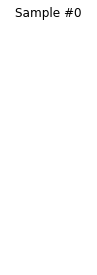

In [52]:
for i in range(len(patientveccs_dataset)):
    patient = patientveccs_dataset[i]

    print(i, patient.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_patient(**patient)

In [53]:
dataloader = DataLoader(patientveccs_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

In [54]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['patient'].size())

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 62, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem.dtype))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object


In [55]:
xtr = torch.FloatTensor(X_train.values)
xts = torch.FloatTensor(X_test.values)
# X_val: validation data for isFraud == 0
xvl = torch.FloatTensor(X_val.values) 
# X_train_fraud: validation data for isFraud == 1
#xvt = torch.FloatTensor(X_train_fraud.values)

xdl = DataLoader(xtr,batch_size=1000)
tdl = DataLoader(xts,batch_size=1000)
vdl = DataLoader(xvl,batch_size=1000)
#fdl = DataLoader(xvt,batch_size=1000)

print(len(X_train.values), len(X_test.values), len(X_val.values)) #, len(X_train_fraud))
#gc.collect()

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [56]:
"""
    params:
        data : data desired to be split
        ratio : validation ratio for split
        
    output:
        train_data, validation_data
"""

def splitter(data, ratio=0.2):
    num = int(ratio*len(data))
    return data[num:], data[:num]

X_train, X_val = splitter(train)
y_train, y_val = splitter(train)

# Check number of data
print(len(X_train), len(X_val), len(y_train), len(y_val))

25189 6297 25189 6297


In [57]:
import os
import time

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import save_image

#from model import StackedAutoEncoder


num_epochs = 1000
batch_size = 128

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

model = StackedAutoEncoder() #.cuda()

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        # Test the quality of our features with a randomly initialzed linear classifier.
        classifier = nn.Linear(512 * 16, 10) #.cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    model.train()
    total_time = time.time()
    correct = 0


In [58]:
print(dataloader)

In [59]:
for i, data in enumerate(dataloader):
    print(i)
    print(data)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1a2c1e0200>
Traceback (most recent call last):
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 21510

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py", line 2800, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2648, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))
  File "pandas/_libs/index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1618, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1626, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 21510


    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/nicenoize/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


In [ ]:
    for i, data in enumerate(dataloader):
        img, target = data
        target = Variable(target) #.cuda()
        img = Variable(img) #.cuda()
        features = model(img).detach()
        prediction = classifier(features.view(features.size(0), -1))
        loss = criterion(prediction, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = prediction.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    total_time = time.time() - total_time

    model.eval()
    img, _ = data
    img = Variable(img) #.cuda()
    features, x_reconstructed = model(img)
    reconstruction_loss = torch.mean((x_reconstructed.data - img.data)**2)

    if epoch % 10 == 0:
        print("Saving epoch {}".format(epoch))
        orig = to_img(img.cpu().data)
        save_image(orig, './imgs/orig_{}.png'.format(epoch))
        pic = to_img(x_reconstructed.cpu().data)
        save_image(pic, './imgs/reconstruction_{}.png'.format(epoch))

    print("Epoch {} complete\tTime: {:.4f}s\t\tLoss: {:.4f}".format(epoch, total_time, reconstruction_loss))
    print("Feature Statistics\tMean: {:.4f}\t\tMax: {:.4f}\t\tSparsity: {:.4f}%".format(
        torch.mean(features.data), torch.max(features.data), torch.sum(features.data == 0.0)*100 / features.data.numel())
    )
    print("Linear classifier performance: {}/{} = {:.2f}%".format(correct, len(dataloader)*batch_size, 100*float(correct) / (len(dataloader)*batch_size)))
    print("="*80)

torch.save(model.state_dict(), './CDAE.pth')
